# Distortion correction

This tutorial shows how to correct images for spatial distortion. Some examples of the tutorial rely on files available in http://www.silx.org/pub/pyFAI/testimages/ and will be downloaded during this tutorial. The minimum version of pyFAI is 0.12.0 (actually dev5)

## Detector definitions

PyFAI features an impressive list of 55 detector definitions contributed often by manufacturers and some other reverse engineerd by scientists. 
Each of them is defined as an invividual class which contains a way to calculate the mask (invalid pixels, gaps,…) and a method to calculate the pixel positions in Cartesian coordinates. 


In [2]:
import pyFAI
all_detectors = list(set(pyFAI.detectors.ALL_DETECTORS.values()))
#Sort detectors according to their name
all_detectors.sort(key=lambda i:i.__name__)
nb_det = len(all_detectors)
print("Number of detectors registered:", nb_det)
for i in all_detectors:
    print(i())

Number of detectors registered: 55
Detector Quantum 210	 Spline= None	 PixelSize= 5.100e-05, 5.100e-05 m
Detector Quantum 270	 Spline= None	 PixelSize= 6.480e-05, 6.480e-05 m
Detector Quantum 315	 Spline= None	 PixelSize= 5.100e-05, 5.100e-05 m
Detector Quantum 4	 Spline= None	 PixelSize= 8.200e-05, 8.200e-05 m
Detector Aarhus	 Spline= None	 PixelSize= 2.500e-05, 2.500e-05 m
Detector ApexII	 PixelSize= 6.000e-05, 6.000e-05 m
Detector aca1300	 PixelSize= 3.750e-06, 3.750e-06 m
Undefined detector
Detector Dexela 2923	 PixelSize= 7.500e-05, 7.500e-05 m
Detector Eiger16M	 PixelSize= 7.500e-05, 7.500e-05 m
Detector Eiger1M	 PixelSize= 7.500e-05, 7.500e-05 m
Detector Eiger4M	 PixelSize= 7.500e-05, 7.500e-05 m
Detector Eiger9M	 PixelSize= 7.500e-05, 7.500e-05 m
Detector Fairchild	 PixelSize= 1.500e-05, 1.500e-05 m
Detector HF-130k	 Spline= None	 PixelSize= 1.500e-04, 1.500e-04 m
Detector HF-1M	 Spline= None	 PixelSize= 1.500e-04, 1.500e-04 m
Detector HF-262k	 Spline= None	 PixelSize= 1.500e-0

## Defining a detector from a spline-file 
For optically coupled CCD detectors, the geometrical distortion is often described by a two-dimensional cubic spline (as in FIT2D) which can be imported into the detector instance and used to calculate the actual pixel position in space (and masked pixels).

At ESRF, mainly FReLoN detectors [J.-C. Labiche, ESRF Newsletter 25, 41 (1996)] are used with spline-file distortion.
Let's download such file and create a detector from it. 

In [25]:
spline_url="http://www.silx.org/pub/pyFAI/testimages/halfccd.spline"

def download(url):
    """download the file given in URL and return its local path"""
    import os
    from urllib.request import urlopen, ProxyHandler, build_opener
    dictProxies = {}
    if "http_proxy" in os.environ:
        dictProxies['http'] = os.environ["http_proxy"]
        dictProxies['https'] = os.environ["http_proxy"]
    if "https_proxy" in os.environ:
        dictProxies['https'] = os.environ["https_proxy"]
    if dictProxies:
        proxy_handler = ProxyHandler(dictProxies)
        opener = build_opener(proxy_handler).open
    else:
        opener = urlopen
    target = os.path.split(url)[-1]
    with open(target,"wb") as dest, opener(url) as src:
        dest.write(src.read())
    return target

spline_file = download(spline_url)

In [4]:
hd = pyFAI.detectors.FReLoN(splineFile=spline_file)
print(hd)
print("Shape: %i, %i"% hd.shape)

Detector FReLoN	 Spline= /users/kieffer/workspace-400/pyFAI/doc/source/usage/tutorial/Distortion/halfccd.spline	 PixelSize= 4.842e-05, 4.684e-05 m
Shape: 1025, 2048


*Note:* the unusual shape of this detector. This is probably a human error when calibrating the detector distortion.

### Visualizing the mask
Every detector contains its mask, defining pixels which are invalid. 
For spline-files defined detectors, all pixels having an offset such as the pixel falls out of the detector are considered as invalid. 

Masked pixel have non-null values and an be displayed as such: 

Populating the interactive namespace from numpy and matplotlib


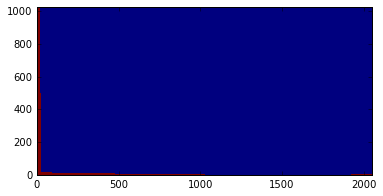

In [5]:
%pylab inline
imshow(hd.mask, origin="lower", interpolation="nearest")


## Detector definition files as NeXus files

Any detector object in pyFAI can be saved into an HDF5 file following the NeXus convention [Könnecke et al., 2015, J. Appl. Cryst. 48, 301-305.]. Detector objects can subsequently be restored from disk, making complex detector definitions that are less error prone. 

In [14]:
h5_file = "halfccd.h5"
if os.path.exists(h5_file): os.unlink(h5_file) 
hd.save(h5_file)
new_det = pyFAI.detector_factory(h5_file)
print(new_det)
print("Mask is the same: ", numpy.allclose(new_det.mask, hd.mask))
print("Pixel positions are the same: ", numpy.allclose(new_det.get_pixel_corners(), hd.get_pixel_corners()))
print("Number of masked pixels", new_det.mask.sum())

FReLoN detector from NeXus file: halfccd.h5	 PixelSize= 4.842e-05, 4.684e-05 m
Mask is the same:  True
Pixel positions are the same:  True
Number of masked pixels 34382


Pixels of an area detector are saved as a four-dimensional data set: i.e. a two-dimensional array of vertices pointing to every corner of each pixel, generating an array of shape (Ny, Nx, Nc, 3), where Nx and Ny are the dimensions of the detector, Nc is the number of corners of each pixel, usually four, and the last entry contains the coordinates of the vertex itself (in the order: Z, Y, X). 

This kind of definition, while relying on large description files, can address some of the most complex detector layouts we will present later.


In [11]:
print("Size of Spline-file:", os.stat('halfccd.spline').st_size)
print("Size of Nexus-file:", os.stat('halfccd.h5').st_size)

Size of Spline-file: 1183
Size of Nexus-file: 21453227


## Modify a detector and saving

One may want to define a new mask (or flat-field) for its detector and save the mask with the detecor defnition. 
Here we create a copy of the detector and reset its mask to enable all pixels in the detector and save this new  detector into another file.

In [16]:
import copy
nomask_file = "nomask.h5"
if os.path.exists(nomask_file): os.unlink(nomask_file) 
nomask = copy.deepcopy(new_det)
nomask.mask = numpy.zeros_like(new_det.mask)
nomask.save(nomask_file)
nomask = pyFAI.detector_factory("nomask.h5")
print("No pixels are masked",nomask.mask.sum())

No pixels are masked 0


### Wrap up
In this section we have seen how detectors are defined in pyFAI, how they can be created, either from the list of parametrized ones, or from spline-files, or from NeXus detector files. We have also seen how to save and subsequently restore this detector again, preserving the modifications mades.

## Distortion correction

Once the position of every single pixel in space is known, one can benefit from the regridding engine of pyFAI adapted to image-distortion. 
The *pyFAI.distortion.Distortion* class is the equivalent of the *pyFAI.AzimuthalIntegrator* for distortion. Provided with a detector definition it enables the correction of [an|a set of] image[s].


In [45]:
from pyFAI.distortion import Distortion
dis = Distortion(nomask)
print(dis)

Distortion correction lut on device None for detector shape (1025, 2048):
NexusDetector detector from NeXus file: nomask.h5	 PixelSize= 4.842e-05, 4.684e-05 m


### FReLoN detector

First load the image to be corrected, than correct it for for distortion.


ERROR:pyFAI.distortion:The image shape ((1024, 2048)) is not the same as the detector ((1025, 2048)). Adapting shape ...
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


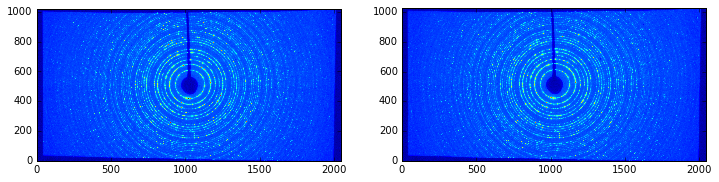

In [59]:
halfccd_img = download("http://www.silx.org/pub/pyFAI/testimages/halfccd.edf")
import fabio
raw = fabio.open(halfccd_img).data
cor = dis.correct(raw)

#then display images side by side
figure(figsize=(12,6))
subplot(1,2,1)
imshow(numpy.log(raw), interpolation="nearest", origin="lower")
subplot(1,2,2)
imshow(numpy.log(cor), interpolation="nearest", origin="lower")

**Nota:** in this case the image size (1024 lines) does not fit the detector number of lines (1025) hence pyFAI complains about it, but patched the image so that it has the right size. 

In this example, the size of the pixels and the shape of the detector is preserved, discarding all pixels falling outside the grid of the detector. 

If one wants all pixels to be conserved by allowing the output array to be larger to accomodate all pixel, just enable the "resize" option in the constructor of *Distortion*:

In [48]:
dis1 = Distortion(hd, resize=True)
print(dis1)
cor = dis1.correct(raw)
print(dis1)
print("After correction, the image has a different shape",cor.shape)

ERROR:pyFAI.distortion:The image shape ((1024, 2048)) is not the same as the detector ((1025, 2048)). Adapting shape ...


Distortion correction lut on device None for detector shape None:
Detector FReLoN	 Spline= /users/kieffer/workspace-400/pyFAI/doc/source/usage/tutorial/Distortion/halfccd.spline	 PixelSize= 4.842e-05, 4.684e-05 m
Distortion correction lut on device None for detector shape (1045, 2052):
Detector FReLoN	 Spline= /users/kieffer/workspace-400/pyFAI/doc/source/usage/tutorial/Distortion/halfccd.spline	 PixelSize= 4.842e-05, 4.684e-05 m
After correction, the image has a different shape (1045, 2052)


### Example of Pixel-detectors: 

#### XPad Flat detector

There has been a striking example in the cover-image of this article http://scripts.iucr.org/cgi-bin/paper?S1600576715004306 where a detector made of multiple modules is *eating up* some rings. 
The first example will be about the regeneration of an "eyes friendly" version of this image.

Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Shape as input and output:

/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log


 (960, 560) (1174, 578)
Conservation of the total intensity: 11120798 1.11208e+07


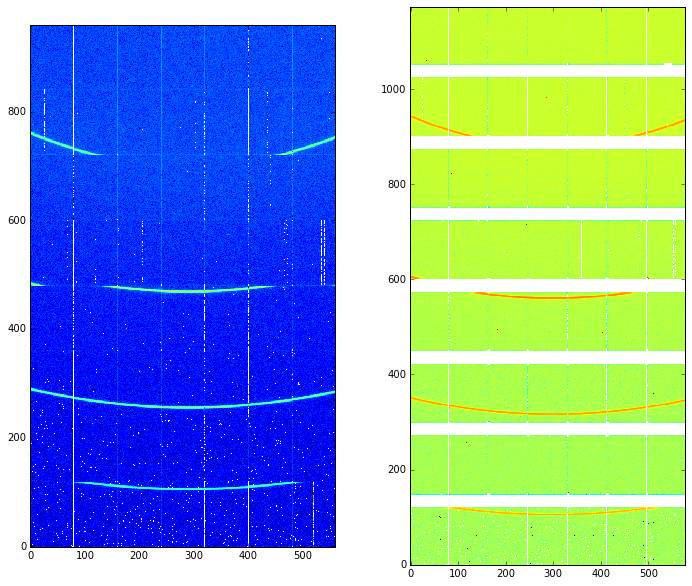

In [62]:
xpad_url = "http://www.silx.org/pub/pyFAI/testimages/LaB6_18.57keV_frame_13.edf"
xpad_file = download(xpad_url)
xpad = pyFAI.detector_factory("Xpad_flat")
print(xpad)
xpad_dis = Distortion(xpad, resize=True)

raw = fabio.open(xpad_file).data
cor = xpad_dis.correct(raw)
print("Shape as input and output:", raw.shape, cor.shape)

#then display images side by side
figure(figsize=(12,10))
subplot(1,2,1)
imshow(numpy.log(raw), interpolation="nearest", origin="lower")
subplot(1,2,2)
imshow(numpy.log(cor), interpolation="nearest", origin="lower")

print("Conservation of the total intensity:", raw.sum(), cor.sum())

#### WOS XPad detector

This is a new **WAXS opened for SAXS** pixel detector from ImXPad (available at ESRF-BM02/D2AM CRG beamline). 
It looks like two of *XPad_flat* detectors side by side with some modules shifted in order to create a hole to accomodate a flight-tube which gathers the SAXS photons to a second detector further away.

The detector definition for this specific detector has directly been done using the metrology informations from the manufacturer and saved as a NeXus detector definition file. 


In [63]:
wos_det = download("http://www.silx.org/pub/pyFAI/testimages/WOS.h5")
wos_img = download("http://www.silx.org/pub/pyFAI/testimages/WOS.edf")
wos = pyFAI.detector_factory(wos_det)
print(wos)
wos_dis = Distortion(wos, resize=True)

raw = fabio.open(wos_img).data
cor = xpad_dis.correct(raw)
print("Shape as input and output:", raw.shape, cor.shape)

#then display images side by side
figure(figsize=(12,10))
subplot(1,2,1)
imshow(numpy.log(raw), interpolation="nearest", origin="lower")
subplot(1,2,2)
imshow(numpy.log(cor), interpolation="nearest", origin="lower")

print("Conservation of the total intensity:", raw.sum(), cor.sum())

AttributeError: 'list' object has no attribute 'name'

**Nota:** Do not use this detector definition file to process data from the WOS@D2AM as it has not (yet) been fully validated and may contain some errors in the pixel positionning.

# Conclusion

PyFAI provides a very comprehensive list of detector definition, versatile enough to address most area detector on the market, and a powerful regridding engine. Both combined into the distrortion correction tool which ensures the conservation of the signal during the transformation (the number of photon counted is preserved during the transformation)

This tutorial did not answer to the question *how to calibrate the distortion of a given detector ?* which is addressed in another tutorial called **detector calibration**.

In [1]:
import os
os.environ["http_proxy"] = "http://proxy.esrf.fr:3128"
        

In [22]:
ls halfccd_img

ls: cannot access halfccd_img: No such file or directory


In [23]:
ls

Distortion.ipynb  halfccd.edf  halfccd.h5  halfccd.spline  nomask.h5


In [24]:
halfccd_img

In [33]:
Distortion?